In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Carga de datos


In [0]:
transform = transforms.Compose([
                                transforms.Resize((28,28)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,))
                                ])

training_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_data = datasets.MNIST(root='./data', train=False , download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size=100, shuffle=False)

#Visualización datos cargados

In [0]:
def img_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0,1)
  return image

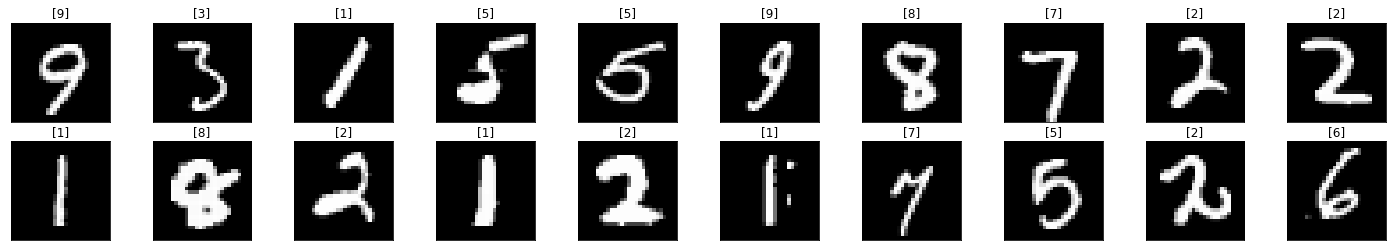

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax  = fig.add_subplot(2,10,idx+1, xticks =[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title([labels[idx].item()])


# Creación y entrenamiento del modelo


In [0]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.epochs = 15

    self.loss_history = []
    self.accuracy_history = []
    self.val_loss_history = []
    self.val_accuracy_history = []

    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    #output_conv1 = (28 - 5 + 2P / Strife) + 1 = 24
    #output_maxpool1 = 24 / 2 = 12
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    #output_conv2 = (12 - 5 + 2P / Strife) + 1 = 8
    #output_maxpool1 = 8 / 2 = 4
    #La entrada a la primera capa de la FC serán 50 imágenes de 4*4
    self.fc1 = nn.Linear(4 * 4 * 50,500)
    self.drop1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)


  def config_optim(self, criterion, optimizer):
    self.criterion = criterion
    self.optimizer = optimizer    
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.drop1(x)
    x = self.fc2(x)
    return x

  def train(self):
    for i in range(self.epochs):

      running_loss = 0.0
      running_corrects = 0

      val_running_loss = 0.0
      val_running_corrects = 0


      for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #inputs = inputs.view(inputs.shape[0], -1) No se requiere aplanar porque se pasa la imagen completa
        outputs = model(inputs)
        loss = self.criterion(outputs, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item()

      else:
        with torch.no_grad():
          for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            #val_inputs = val_inputs.view(val_inputs.shape[0], -1) No se requiere aplanar porque se pasa la imagen completa
            val_outputs = model(val_inputs)
            val_loss = self.criterion(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data)
            val_running_loss += val_loss.item()

        epoch_loss = running_loss / len(training_loader)
        epoch_accuracy  = running_corrects / len(training_loader)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_accuracy  = val_running_corrects / len(validation_loader)

        self.loss_history.append(epoch_loss)
        self.accuracy_history.append(epoch_accuracy)

        self.val_loss_history.append(val_epoch_loss)
        self.val_accuracy_history.append(val_epoch_accuracy)

        print("Epoch: ", i+1)
        print("Training Loss: {:.4f} - Training Accuraccy: {:.4f}".format(epoch_loss, epoch_accuracy.item()))
        print("Validation Loss: {:.4f} - Validation Accuracy: {:.4f}".format(val_epoch_loss, val_epoch_accuracy.item()))


  def predict(self, images):
    images = images.to(device)
    img = images[0].unsqueeze(0).unsqueeze(0)
    #img = img.view(img.shape[0], -1)
    output = model(img)
    _, pred = torch.max(output, 1)
    return pred

In [7]:
model = LeNet().to(device)
model.config_optim(nn.CrossEntropyLoss(), torch.optim.Adam(params=model.parameters(), lr=0.00001))
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [8]:
model.train()

Epoch:  1
Training Loss: 1.9070 - Training Accuraccy: 53.0000
Validation Loss: 1.2903 - Validation Accuracy: 74.0000
Epoch:  2
Training Loss: 0.9082 - Training Accuraccy: 79.0000
Validation Loss: 0.6277 - Validation Accuracy: 83.0000
Epoch:  3
Training Loss: 0.5473 - Training Accuraccy: 85.0000
Validation Loss: 0.4457 - Validation Accuracy: 87.0000
Epoch:  4
Training Loss: 0.4175 - Training Accuraccy: 88.0000
Validation Loss: 0.3575 - Validation Accuracy: 89.0000
Epoch:  5
Training Loss: 0.3447 - Training Accuraccy: 90.0000
Validation Loss: 0.2995 - Validation Accuracy: 91.0000
Epoch:  6
Training Loss: 0.2956 - Training Accuraccy: 91.0000
Validation Loss: 0.2545 - Validation Accuracy: 92.0000
Epoch:  7
Training Loss: 0.2580 - Training Accuraccy: 92.0000
Validation Loss: 0.2269 - Validation Accuracy: 93.0000
Epoch:  8
Training Loss: 0.2310 - Training Accuraccy: 93.0000
Validation Loss: 0.2067 - Validation Accuracy: 93.0000
Epoch:  9
Training Loss: 0.2085 - Training Accuraccy: 93.0000
Va

# Visualización de resultados


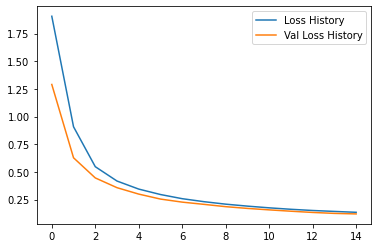

In [9]:
plt.plot(model.loss_history, label="Loss History")
plt.plot(model.val_loss_history, label="Val Loss History")
plt.legend()

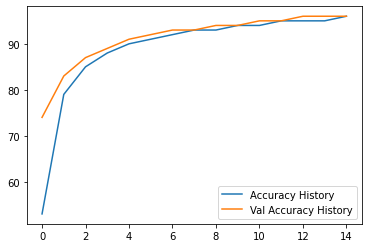

In [10]:
plt.plot(model.accuracy_history, label="Accuracy History")
plt.plot(model.val_accuracy_history, label="Val Accuracy History")
plt.legend()

# Prueba con imagen de internet


<Response [200]>


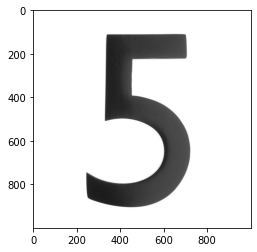

In [11]:
import requests
from PIL import Image
import PIL.ImageOps

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'

response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

print(response)

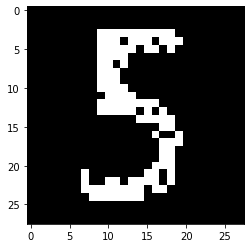

In [12]:
img = img.convert('L')
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(img_convert(img))

In [13]:
pred = model.predict(img)
print(pred)

tensor([5], device='cuda:0')
